In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq
import statsmodels.api as sm
import scipy
from scipy.stats import norm
from scipy.stats.mstats import gmean

from statsmodels.nonparametric.smoothers_lowess import lowess

from numpy.lib.stride_tricks import sliding_window_view
import functions_mem as fm

from datetime import datetime
from pathlib import Path

# Read data

In [2]:
df = pd.read_parquet('/opt/storage/shared/aesop/aesop_shared/ensamble_modelling/aesop_2026_01_21_mun.parquet')

sea_key = pd.read_parquet('/opt/storage/shared/aesop/aesop_shared/ensamble_modelling/def_sea_MEM_out_27_01_2026.parquet')

In [3]:
sea_key.head()

,epiyear,r_j_estr,k_start,k_end,co_ibge,season_def,delta_used,co_uf,nm_uf
0,2017,27,2,28,110001,season_w39,0.022,11,Rondônia
1,2018,13,35,47,110001,season_w39,0.022,11,Rondônia
2,2019,15,36,50,110001,season_w39,0.022,11,Rondônia
3,2020,12,41,52,110001,season_w39,0.022,11,Rondônia
4,2021,18,17,34,110001,season_w39,0.022,11,Rondônia


In [4]:
lst = ['co_uf','nm_uf','nm_municipio','co_ibge', 'epiyear', 'epiweek','year_week', 'atend_totais', 'atend_ivas','ra_atend_ivas','ra_atend_ivas_ma',]

df = df[lst]

In [5]:
df[df.nm_municipio == 'São Paulo']

,co_uf,nm_uf,nm_municipio,co_ibge,epiyear,epiweek,year_week,atend_totais,atend_ivas,ra_atend_ivas,ra_atend_ivas_ma
1807288,35,São Paulo,São Paulo,355030,2017,1,2017-01,356,1,0.28,0.00
1807289,35,São Paulo,São Paulo,355030,2017,2,2017-02,245,0,0.00,0.00
1807290,35,São Paulo,São Paulo,355030,2017,3,2017-03,165,0,0.00,0.00
1807291,35,São Paulo,São Paulo,355030,2017,4,2017-04,133,0,0.00,0.07
1807292,35,São Paulo,São Paulo,355030,2017,5,2017-05,190,2,1.05,0.26
...,...,...,...,...,...,...,...,...,...,...,...
1807755,35,São Paulo,São Paulo,355030,2025,51,2025-51,249134,12816,5.14,6.62
1807756,35,São Paulo,São Paulo,355030,2025,52,2025-52,111685,6164,5.52,6.15
1807757,35,São Paulo,São Paulo,355030,2025,53,2025-53,70560,3270,4.63,5.45
1807758,35,São Paulo,São Paulo,355030,2026,1,2026-01,2462,46,1.87,4.29


# Select a city

In [7]:
city = 110004

week_start_seas = sea_key.loc[sea_key.co_ibge == city, "season_def"].str.slice(-2).astype(int).iloc[0]

set_muni = df[df.co_ibge == city]

set_muni  = fm.add_sea(set_muni, n_week = week_start_seas)

set_muni = set_muni.assign(atend_ivas_ma = set_muni["atend_ivas"].rolling(window=4, min_periods=1).mean())

delta_used = sea_key.loc[sea_key.co_ibge == city, "delta_used"].iloc[0]

summary, details = fm.mem_epidemic_period(set_muni, col_year = f'season_w{week_start_seas}', col_series = 'atend_ivas_ma', delta= delta_used)


/home/juliane.oliveira/workspace/IDEA_model/tmp/functions_mem.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[year_col]


In [8]:
f'season_w{week_start_seas}'

'season_w52'

In [9]:
summary

,epiyear,r_j_estr,k_start,k_end
0,2017,0,1,0
1,2018,8,30,37
2,2019,12,7,18
3,2020,17,26,42
4,2021,13,7,19
5,2022,0,1,0
6,2023,20,14,33
7,2024,8,17,24
8,2025,21,14,34
9,2026,4,1,4


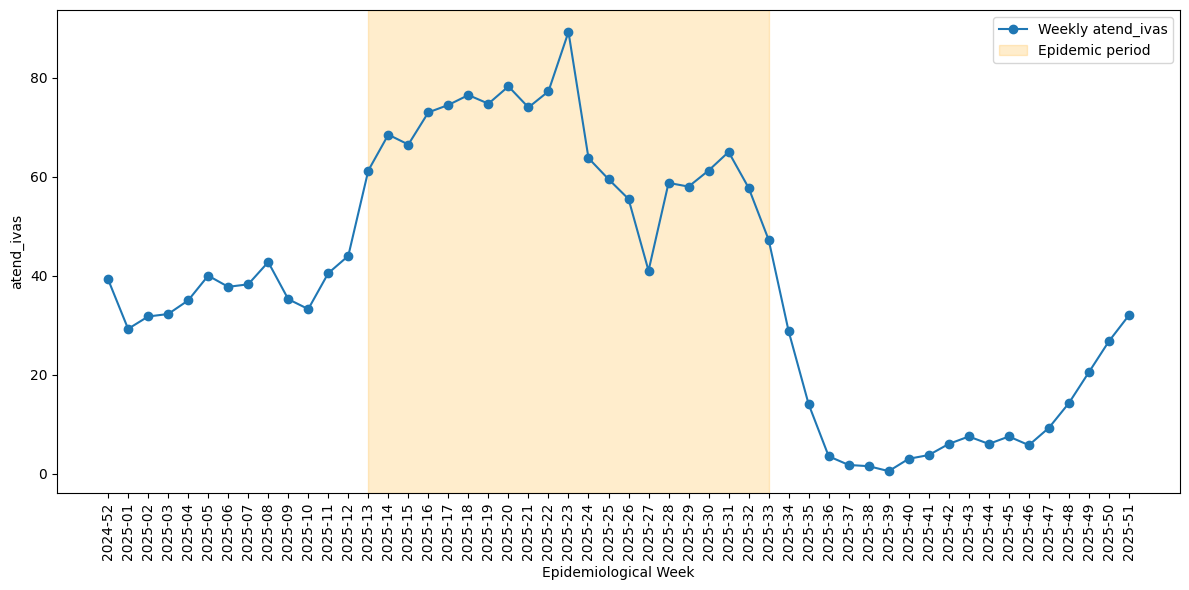

In [13]:
fig, ax = plt.subplots(figsize=(12,6))

year = 2025
#'season_w42' # epiyear

season = set_muni[set_muni[f'season_w{week_start_seas}'] == year].reset_index()

k_s = summary[summary['epiyear'] == year].k_start.max()

k_e = summary[summary['epiyear'] == year].k_end.max()
        
# plot weekly values
#ax.plot(season["year_week"], season['atend_ivas'], marker="o", label="Weekly atend_ivas")
ax.plot(season["year_week"], season['atend_ivas_ma'], marker="o", label="Weekly atend_ivas")
        
# highlight epidemic window
ax.axvspan(season.loc[k_s-1, "year_week"], season.loc[k_e-1, "year_week"], 
                   color="orange", alpha=0.2, label="Epidemic period")
        
        
# labels
plt.xticks(rotation=90)
ax.set_xlabel("Epidemiological Week")
ax.set_ylabel("atend_ivas")
ax.legend()
plt.tight_layout()
plt.show()

#  Baseline and Epidemic threshold

In [14]:
baseline,  post_baseline, epidemic_threshold, post_threshold, df_thresholds_intensity  = fm.baseline_thresholds(
    set_muni,
    summary,
    lst_sea=[2022, 2023, 2024],
    value_col="atend_ivas",
    col_year = f'season_w{week_start_seas}',
    col_week="epiweek"
)

/home/juliane.oliveira/workspace/IDEA_model/tmp/functions_mem.py:358: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season["id"] = range(1, len(season) + 1)
/home/juliane.oliveira/workspace/IDEA_model/tmp/functions_mem.py:358: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season["id"] = range(1, len(season) + 1)
/home/juliane.oliveira/workspace/IDEA_model/tmp/functions_mem.py:358: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [15]:
baseline

45.84375

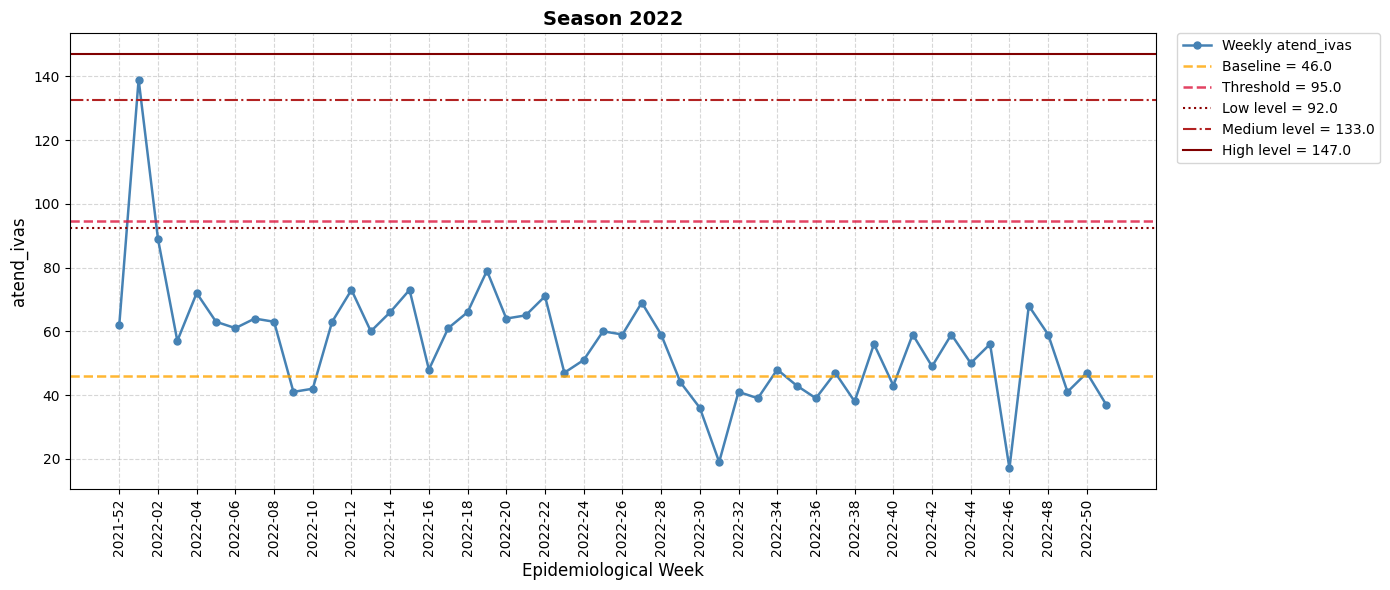

In [16]:
fig, ax = plt.subplots(figsize=(14,6))

year = 2022

# subset the season data
season = set_muni[set_muni[f'season_w{week_start_seas}'] == year].reset_index(drop=True)

# get start and end from summary
k_s = int(summary.loc[summary.epiyear == year, "k_start"].iloc[0])
k_e = int(summary.loc[summary.epiyear == year, "k_end"].iloc[0])

# plot weekly values
ax.plot(season["year_week"], season['atend_ivas'], 
        marker="o", markersize=5, linewidth=1.8, color="steelblue", 
        label="Weekly atend_ivas")

# thresholds
ax.axhline(baseline, color="orange", alpha=0.8, linestyle="--", linewidth=1.8,
           label=f"Baseline = {round(baseline,0)}")

#ax.axhline(post_baseline, color="orange", alpha=0.8, linestyle="--", linewidth=1.8,
#           label=f"Post - Baseline = {round(post_baseline,0)}")


ax.axhline(epidemic_threshold, color="crimson", alpha=0.8, linestyle="--", linewidth=1.8,
           label=f"Threshold = {round(epidemic_threshold,0)}")

#ax.axhline(post_threshold, color="crimson", alpha=0.8, linestyle="--", linewidth=1.8,
#           label=f"Epidemic threshold = {round(post_threshold,0)}")


ax.axhline(df_thresholds_intensity.value.iloc[0], color="darkred", linestyle=":", linewidth=1.5,
           label=f"Low level = {round(df_thresholds_intensity.value.iloc[0],0)}")
ax.axhline(df_thresholds_intensity.value.iloc[1], color="firebrick", linestyle="-.", linewidth=1.5,
           label=f"Medium level = {round(df_thresholds_intensity.value.iloc[1],0)}")
ax.axhline(df_thresholds_intensity.value.iloc[2], color="maroon", linestyle="-", linewidth=1.5,
           label=f"High level = {round(df_thresholds_intensity.value.iloc[2],0)}")

# labels & formatting
ax.set_xlabel("Epidemiological Week", fontsize=12)
ax.set_ylabel("atend_ivas", fontsize=12)
ax.set_title(f"Season {year}", fontsize=14, fontweight="bold")

# x-axis ticks (reduce clutter)
ax.set_xticks(season["year_week"][::2])  # every 2 weeks
ax.set_xticklabels(season["year_week"][::2], rotation=90)

# grid
ax.grid(True, linestyle="--", alpha=0.5)

# legend outside
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

plt.tight_layout()
plt.show()
